In [10]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [11]:
import torch
from sam.build_sam import sam_model_registry
from sam.automatic_mask_generator import SamAutomaticMaskGenerator
from sam.predictor import SamPredictor
from sam.build_sam import SAM_Model
from data_builder.build_dataset import PlanetscopeDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import linear_sum_assignment
from torch.utils.data import DataLoader
import gc

In [2]:
ROOT_PATH = 'C://Users/anind/Dropbox (ASU)/ASU/Kerner-Lab/SAT-SAM(Dataset)/ps_rwanda/all_dataset/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  ax.set_autoscale_on(False)
  for mask in masks:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()
  del mask
  gc.collect()

In [13]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-large", device=device)

c:\Users\anind\anaconda3\envs\dl4cv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\anind\anaconda3\envs\dl4cv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anind\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this articl

In [14]:
dataset = PlanetscopeDataset(ROOT_PATH, train=False)

In [15]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_iou_matrix(target_masks, predicted_masks):
    num_target_masks = len(target_masks)
    num_predicted_masks = len(predicted_masks)

    print("num_target_masks: ", num_target_masks)
    print("num_predicted_masks: ", num_predicted_masks)

    iou_matrix = np.zeros((num_target_masks, num_predicted_masks))
    for i in range(num_target_masks):
        for j in range(num_predicted_masks):
            iou_matrix[i, j] = iou(target_masks[i], predicted_masks[j])

    return iou_matrix

def calculate_iou(target_masks, predicted_masks):
    iou_matrix = calculate_iou_matrix(target_masks, predicted_masks)
    # Use the Hungarian algorithm to find the best assignment
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)

    print("row_ind: ", row_ind)
    print("col_ind: ", col_ind)

    total_iou = 0.0
    for i, j in zip(row_ind, col_ind):
        total_iou += iou_matrix[i, j]

    average_iou = total_iou / len(row_ind)
    return average_iou

def calculate_precision_recall(matched_ious, num_pred_instances, num_gt_instances, threshold=0.5):
    num_true_positives = len(matched_ious[matched_ious >= threshold])
    num_false_positives = num_pred_instances - num_true_positives
    num_false_negatives = num_gt_instances - num_true_positives
    precision = num_true_positives / (num_true_positives + num_false_positives)
    recall = num_true_positives / (num_true_positives + num_false_negatives)
    
    return precision, recall

In [16]:
sam_image, rpn_image, target, ensemble = dataset[0]

In [17]:
outputs = generator(sam_image, points_per_batch=64)

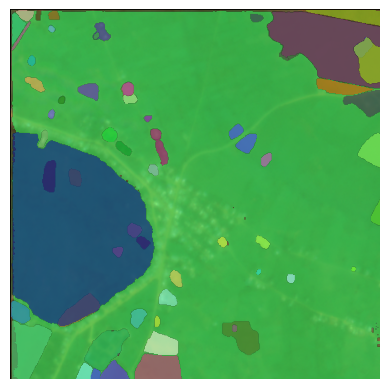

In [19]:
masks = outputs["masks"]
show_masks_on_image(sam_image, masks)

In [20]:
iou_score = calculate_iou(target_masks=np.array(target['masks']), predicted_masks=np.array(masks, dtype=np.uint8))
print("Average IoU Score: ", iou_score)

num_target_masks:  1
num_predicted_masks:  64
row_ind:  [0]
col_ind:  [59]
Average IoU Score:  0.2949298325033952


In [ ]:
iou_scores = []

for i, (sam_image, rpn_image, target, ensemble)  in enumerate(dataset): 
    try:
        prediction = sam_automatic_mask_generator.generate(sam_image)

        iou_score = calculate_iou(target_masks=np.array(target['masks']), predicted_masks=np.array(high_res_masks))
        print("Image Id: ", i, " Average IoU Score: ", iou_score)

        iou_scores.append(iou_score)
    except:
        print("Error in image: ", i)
        continue

In [ ]:
np.mean(iou_scores)